## Notebook Setup and Uploading of Data to S3

In [19]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
!pip install -Uq altair


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


## TO ADD SAGEMAKER VERSIONING

In [21]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd

import sagemaker

In [22]:
!mkdir -p data
digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target
digits_df.to_csv('data/digits.csv', index=False)

In [23]:
BUCKET = sagemaker.Session().default_bucket()
s3_data_url = f's3://{BUCKET}/digits-demo/data'
!aws s3 sync data/ {s3_data_url} --exclude '*' --include 'digits.csv'

upload: data/digits.csv to s3://sagemaker-us-east-1-734664314071/digits-demo/data/digits.csv


## Preparing Training Scripts

In [24]:
!mkdir -p src
import sys
sys.path.append('src')

## TO ADD COMMENT ON ADDING YOUR OWN LIBRARIES

In [25]:
%%writefile src/requirements.txt

#scikit-learn
# ^^^ Not necessary to specify as we will select the proper container later on that already 
# contains sklearn. Checkout the use of SKLearn in "Training in Containers" below

Overwriting src/requirements.txt


In [26]:
%%writefile src/train.py

#!/usr/bin/env python
import argparse
import os
import traceback
from pathlib import Path

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import joblib

def fit(train_dir, n_estimators, max_depth, min_samples_leaf, max_features, min_weight_fraction_leaf):
    
    digits = pd.read_csv(Path(train_dir)/'digits.csv')
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(digits.iloc[:, :-1], digits.iloc[:, -1], test_size=.2)
    
    m = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth, 
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               min_weight_fraction_leaf=min_weight_fraction_leaf)
    m.fit(Xtrain, ytrain)
    predicted = m.predict(Xtest)
    pre, rec, f1, _ = precision_recall_fscore_support(ytest, predicted, pos_label=1, average='weighted')
    
    print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')
    
    return m

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max-depth', type=int, default=10)
    parser.add_argument('--min-samples-leaf', type=int, default=1)
    parser.add_argument('--max-features', type=str, default='auto')
    parser.add_argument('--min-weight-fraction-leaf', type=float, default=0.01)

    args, _ = parser.parse_known_args()
    trained_model = fit(train_dir=args.train, 
                        n_estimators=args.n_estimators, 
                        max_depth=args.max_depth,
                        min_samples_leaf=args.min_samples_leaf,
                        max_features=args.max_features,
                        min_weight_fraction_leaf=args.min_weight_fraction_leaf)
    
    joblib.dump(trained_model, os.path.join(args.model_dir, 'model.joblib'))   


Overwriting src/train.py


In [27]:
%%time
# Running the code from within the notebook. It would then be possible to use the Python Debugger, pdb.
from train import fit
fit('data', 100, 10, 1, 'auto', 0.01)

pre: 0.954 rec: 0.953 f1: 0.953
CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 374 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.01, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
# We could also run it directly from the command line
!cd src && python train.py --train ../data/ --model-dir /tmp/ --n-estimators 100

pre: 0.948 rec: 0.944 f1: 0.945


## Training in Containers

You can bring your own model to Amazon SageMaker . You can find more information on this page: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-script-mode/sagemaker-script-mode.html

In [29]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

In [30]:
metric_definitions = [{'Name': 'Valid:Precision',  'Regex': r'pre:\s+(-?[0-9\.]+)'},
                      {'Name': 'Valid:Recall',     'Regex': r'rec:\s+(-?[0-9\.]+)'},
                      {'Name': 'Valid:F1',         'Regex': r'f1:\s+(-?[0-9\.]+)'}]                                 

In [31]:
estimator = SKLearn('train.py',
                    source_dir='src',
                    role=get_execution_role(),
                    instance_type= 'ml.m5.large',
                    instance_count=1,
                    framework_version='0.23-1',
                    metric_definitions=metric_definitions,
                    
                    use_spot_instances= True,
                    max_run=  60 * 60 * 24,
                    max_wait= 60 * 60 * 24,
                    
                    hyperparameters = {'n-estimators': 100,
                                       'max-depth': 10,
                                       'min-samples-leaf': 1,
                                       'max-features': 'auto',
                                       'min-weight-fraction-leaf': 0.1})

In [ ]:
print(s3_data_url)
estimator.fit({'train': s3_data_url}, wait=True)

s3://sagemaker-us-east-1-734664314071/digits-demo/data
2022-11-04 14:19:31 Starting - Starting the training job...
2022-11-04 14:19:55 Starting - Preparing the instances for trainingProfilerReport-1667571571: InProgress
......
2022-11-04 14:21:00 Downloading - Downloading input data......
2022-11-04 14:22:00 Training - Downloading the training image.

---
Now let's run Hyperparameter Optimization (HPO) for our model.

## Submit Automatic Model Tuning Jobs - Grid

We don't need define MaxNumberofJobs for Grid strategy.

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


hpt_ranges = {#"eta": CategoricalParameter(['0.1', '0.2', '0.3', '0.4', '0.5']),
               #       "alpha": CategoricalParameter(['0.1', '0.2'])}
              'n-estimators': CategoricalParameter([1, 100, 200]),
              'max-depth': CategoricalParameter([1, 10, 20]), 
              'min-samples-leaf': CategoricalParameter([1, 5, 10]),
              'min-weight-fraction-leaf': CategoricalParameter([0.01, 0,25, 0.5]),
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])}



tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'grid',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:F1',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Grid',
                    'max_jobs': 10     # defined as the number of hyperparameter candidates for the grid search
                   }

In [ ]:
grid_tuner = HyperparameterTuner(**tuner_parameters)
grid_tuner.fit({'train': s3_data_url}, wait=False)
grid_tuner_name = grid_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {grid_tuner_name}.')

## Submit Automatic Model Tuning Jobs - Random

In [16]:
n = 50
k = 2

hpt_ranges = {'n-estimators': IntegerParameter(1, 200),
              'max-depth': IntegerParameter(1, 20), 
              'min-samples-leaf': IntegerParameter(1, 10),
              'min-weight-fraction-leaf': ContinuousParameter(0.01, 0.5),
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])}

tuner_parameters = {'estimator': estimator,
                    'base_tuning_job_name': 'random',
                    'metric_definitions': metric_definitions,
                    
                    'objective_metric_name': 'Valid:F1',
                    'objective_type': 'Maximize',
                    'hyperparameter_ranges': hpt_ranges,
                    'strategy': 'Random',
                    
                    'max_jobs': n,
                    'max_parallel_jobs': k} # With 'random' we could use a much higher parallelization here, 
                                            # as all trials/jobs are independent

In [16]:
random_tuner = HyperparameterTuner(**tuner_parameters)
random_tuner.fit({'train': s3_data_url}, wait=False)
random_tuner_name = random_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {random_tuner_name}.')

tuning job submitted: random-220809-1018.


## Submit Automatic Model Tuning Jobs - Bayesian

In [17]:
tuner_parameters['strategy']             = 'Bayesian'
tuner_parameters['base_tuning_job_name'] = 'bayesian'
tuner_parameters['max_jobs'] = n
tuner_parameters['max_parallel_jobs'] = k

In [18]:
bayesian_tuner = HyperparameterTuner(**tuner_parameters)
bayesian_tuner.fit({'train': s3_data_url}, wait=False)
bayesian_tuner_name = bayesian_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {bayesian_tuner_name}.')

tuning job submitted: bayesian-220809-1018.


In [19]:
grid_tuner.wait()
random_tuner.wait()
bayesian_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Submit Automatic Model Tuning Jobs - Hyperband

In [54]:
del HyperparameterTuner

In [56]:
tuner_parameters['strategy']             = 'Hyperband'
tuner_parameters['base_tuning_job_name'] = 'hyperband'
tuner_parameters['early_stopping_type'] = 'Off'
#tuner_parameters['strategy_config'] = sagemaker.tuner.StrategyConfig

In [46]:
sagemaker.tuner.StrategyConfig = {"MinResource": 10, "MaxResource": 100}

In [48]:
print(sagemaker.tuner.StrategyConfig)

{'MinResource': 10, 'MaxResource': 100}


In [57]:
hyperband_tuner = HyperparameterTuner(**tuner_parameters)
hyperband_tuner.fit({'train': s3_data_url}, wait=False)
hyperband_tuner_name = hyperband_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {hyperband_tuner_name}.')

ClientError: An error occurred (ValidationException) when calling the CreateHyperParameterTuningJob operation: MaxResource parameter is not provided and could not be inferred from provided static hyperparameters of TrainingJobDefinition.

In [ ]:
random_tuner.wait()
bayesian_tuner.wait()
grid_tuner.wait()
hyperband_tuner.wait()

## Review Results

In [20]:
from job_analytics import *
from reporting_util import *

import altair as alt
_ = alt.data_transformers.disable_max_rows()
alt.renderers.enable('mimetype')

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)  # Don't truncate TrainingJobName        

In [21]:
tuning_jobs = [random_tuner, bayesian_tuner]

### Random

Tuning job random-220809-1018        status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.0560000017285347 Highest 0.8500000238418579


max-depth max-features  min-samples-leaf  min-weight-fraction-leaf  n-estimators                  TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds       TuningJobName  Valid:F1
43       16.0       "auto"               5.0                  0.076568          14.0  random-220809-1018-007-3ddeece7         Completed 2022-08-09 10:32:34+02:00 2022-08-09 10:34:32+02:00                       118.0  random-220809-1018     0.850
5        13.0       "sqrt"               4.0                  0.056855           5.0  random-220809-1018-045-226b56fd         Completed 2022-08-09 11:48:46+02:00 2022-08-09 11:50:49+02:00                       123.0  random-220809-1018     0.842
23       20.0       "sqrt"               4.0                  0.055537           7.0  random-220809-1018-027-ad716eac         Completed 2022-08-09 11:11:53+02:00 2022-08-09 11:13:56+02:00                       123.0  random-220809-1018     0.838
9        16.0       "sqrt"               8.0                  0.092594          30.0  random-220809-1018-041-4673fb30         Completed 2022-08-09 11:40:15+02:00 2022-08-09 11:42:18+02:00                       123.0  random-220809-1018     0.834
31        4.0       "auto"               7.0                  0.142276         107.0  random-220809-1018-019-5732a914         Completed 2022-08-09 10:55:54+02:00 2022-08-09 10:57:56+02:00                       122.0  random-220809-1018     0.831
6        20.0       "auto"               7.0                  0.294324         120.0  random-220809-1018-044-cfd15090         Completed 2022-08-09 11:44:40+02:00 2022-08-09 11:46:37+02:00                       117.0  random-220809-1018     0.814
12       17.0       "auto"               4.0                  0.243849         142.0  random-220809-1018-038-d9aa8cc3         Completed 2022-08-09 11:32:40+02:00 2022-08-09 11:34:37+02:00                       117.0  random-220809-1018     0.795
42       19.0       "sqrt"               6.0                  0.165223          39.0  random-220809-1018-008-c8ff197a         Completed 2022-08-09 10:32:46+02:00 2022-08-09 10:34:43+02:00                       117.0  random-220809-1018     0.789
16        4.0       "auto"               2.0                  0.275400          42.0  random-220809-1018-034-beb03bf8         Completed 2022-08-09 11:24:38+02:00 2022-08-09 11:26:35+02:00                       117.0  random-220809-1018     0.782
38       11.0       "log2"              10.0                  0.174334          23.0  random-220809-1018-012-9e275a45         Completed 2022-08-09 10:40:53+02:00 2022-08-09 10:42:56+02:00                       123.0  random-220809-1018     0.782

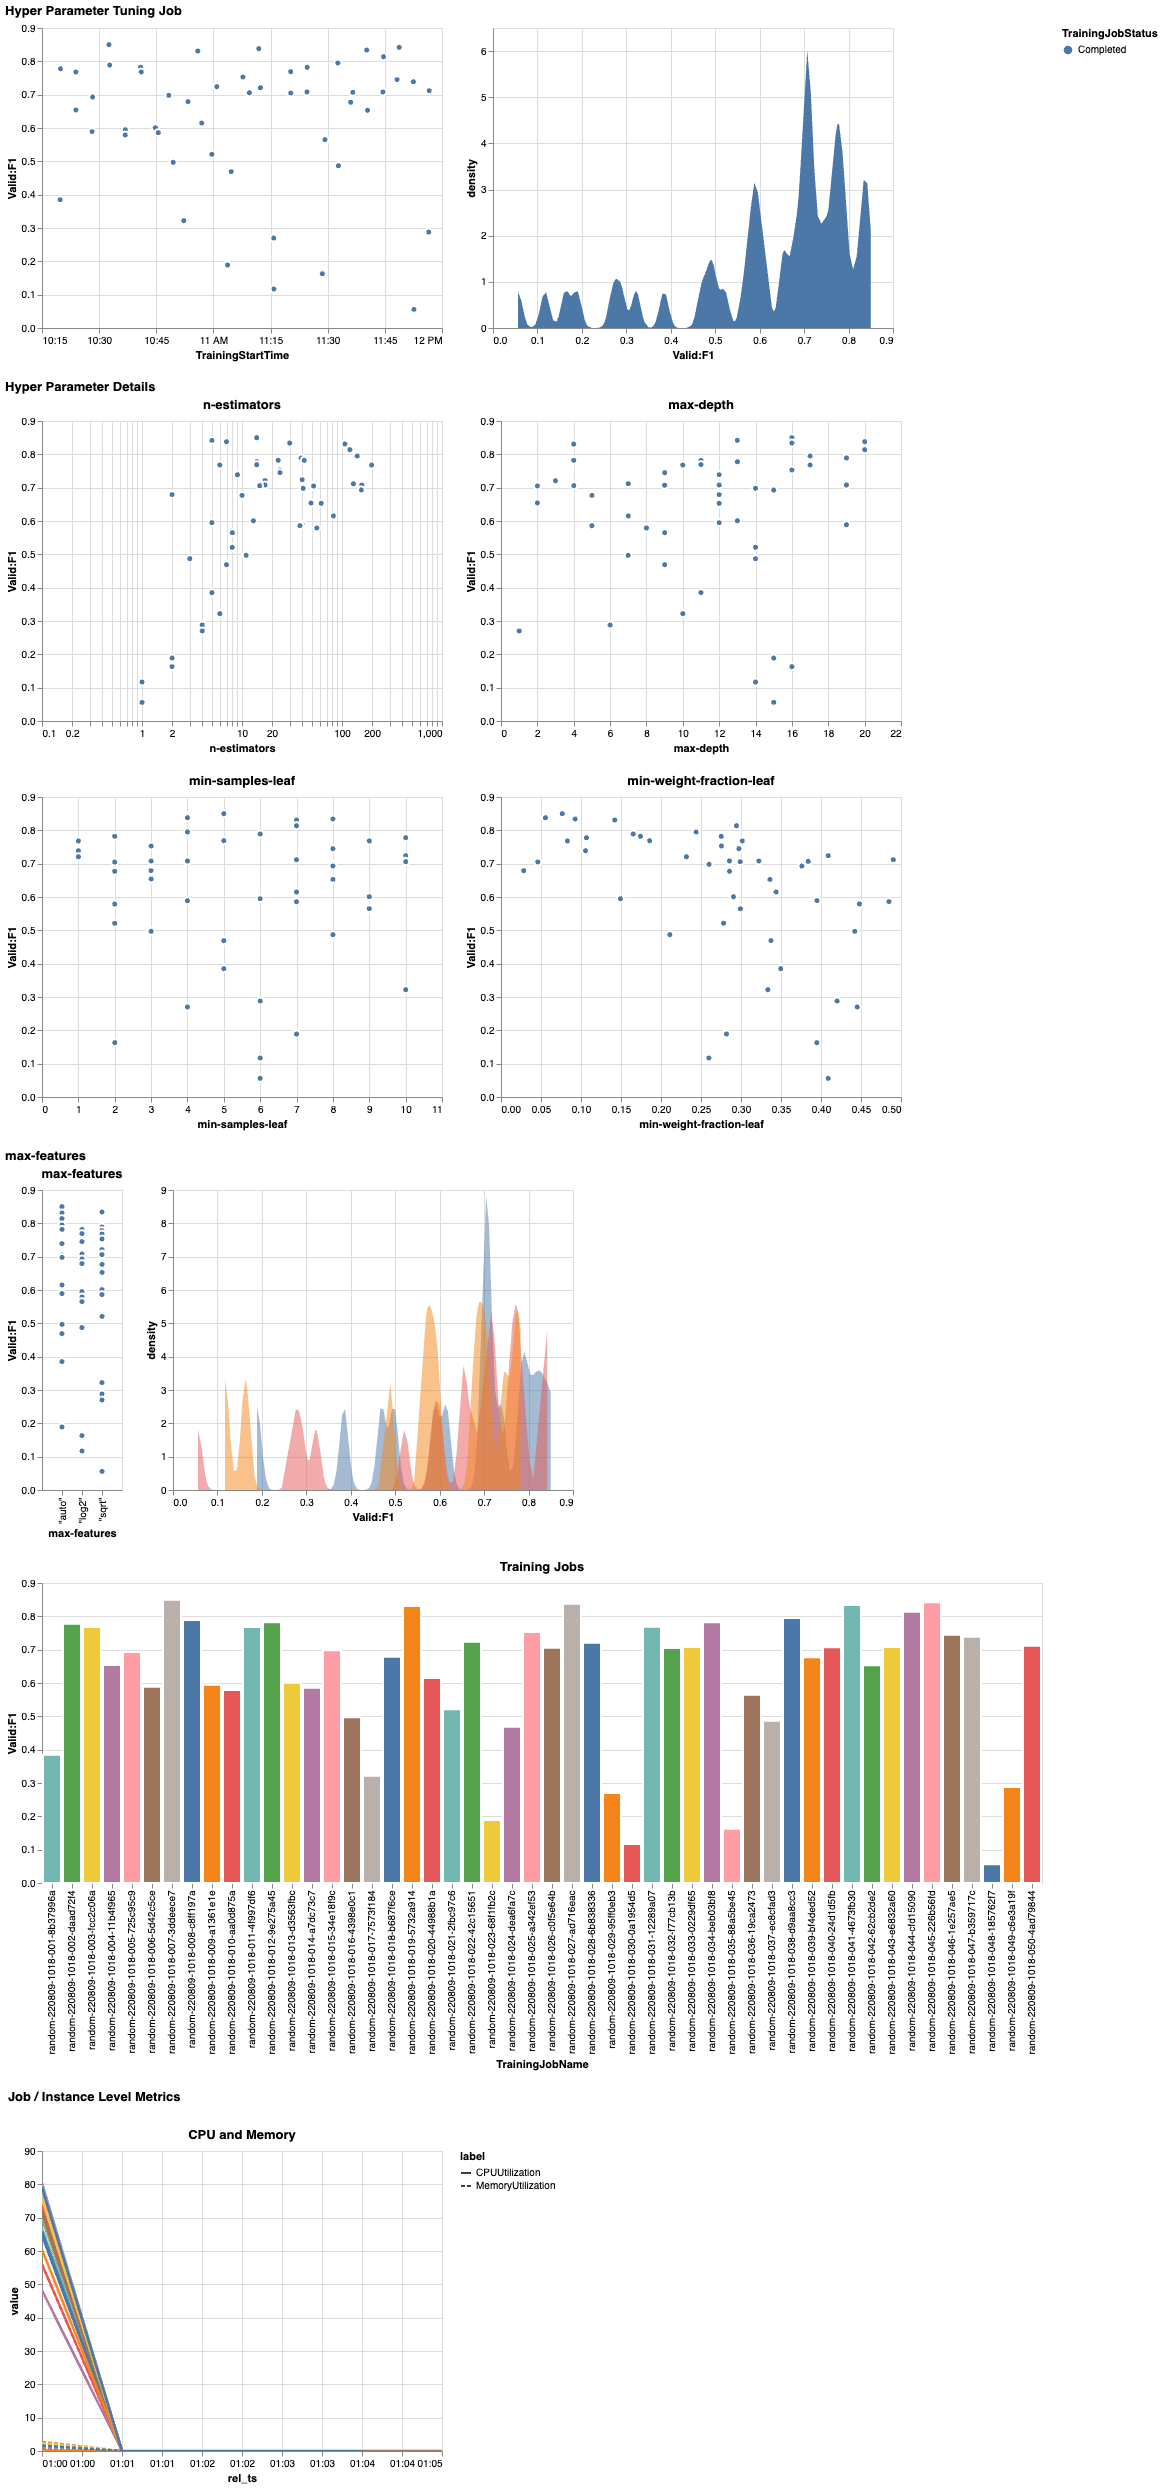

In [22]:
analyze_hpo_job(random_tuner)

### Bayesian

Tuning job bayesian-220809-1018      status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.05550000071525574 Highest 0.9750000238418579


max-depth max-features  min-samples-leaf  min-weight-fraction-leaf  n-estimators                    TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds         TuningJobName  Valid:F1
33       10.0       "log2"               9.0                  0.010000          40.0  bayesian-220809-1018-017-7a54dbfa         Completed 2022-08-09 10:51:46+02:00 2022-08-09 10:53:43+02:00                       117.0  bayesian-220809-1018     0.975
0        20.0       "log2"               5.0                  0.010000         200.0  bayesian-220809-1018-050-41e7420f         Completed 2022-08-09 11:54:46+02:00 2022-08-09 11:56:38+02:00                       112.0  bayesian-220809-1018     0.967
36        9.0       "log2"               4.0                  0.010578          79.0  bayesian-220809-1018-014-b24a2e4f         Completed 2022-08-09 10:43:39+02:00 2022-08-09 10:46:20+02:00                       161.0  bayesian-220809-1018     0.966
30       10.0       "auto"               1.0                  0.018942          58.0  bayesian-220809-1018-020-60efde11         Completed 2022-08-09 10:55:49+02:00 2022-08-09 10:57:55+02:00                       126.0  bayesian-220809-1018     0.966
1        18.0       "auto"               4.0                  0.010000         110.0  bayesian-220809-1018-049-272b5d43         Completed 2022-08-09 11:54:25+02:00 2022-08-09 11:56:25+02:00                       120.0  bayesian-220809-1018     0.964
14       10.0       "sqrt"               9.0                  0.010000         114.0  bayesian-220809-1018-036-aa8754cb         Completed 2022-08-09 11:26:34+02:00 2022-08-09 11:28:36+02:00                       122.0  bayesian-220809-1018     0.961
35       10.0       "auto"               1.0                  0.010376         200.0  bayesian-220809-1018-015-c02e4a9b         Completed 2022-08-09 10:47:39+02:00 2022-08-09 10:49:36+02:00                       117.0  bayesian-220809-1018     0.958
12       10.0       "log2"               2.0                  0.010000         103.0  bayesian-220809-1018-038-be317815         Completed 2022-08-09 11:30:30+02:00 2022-08-09 11:32:32+02:00                       122.0  bayesian-220809-1018     0.953
19       10.0       "auto"               8.0                  0.010000         200.0  bayesian-220809-1018-031-95d670ac         Completed 2022-08-09 11:18:31+02:00 2022-08-09 11:20:33+02:00                       122.0  bayesian-220809-1018     0.953
32       10.0       "log2"               6.0                  0.010000         200.0  bayesian-220809-1018-018-73f2099c         Completed 2022-08-09 10:52:09+02:00 2022-08-09 10:54:11+02:00                       122.0  bayesian-220809-1018     0.952

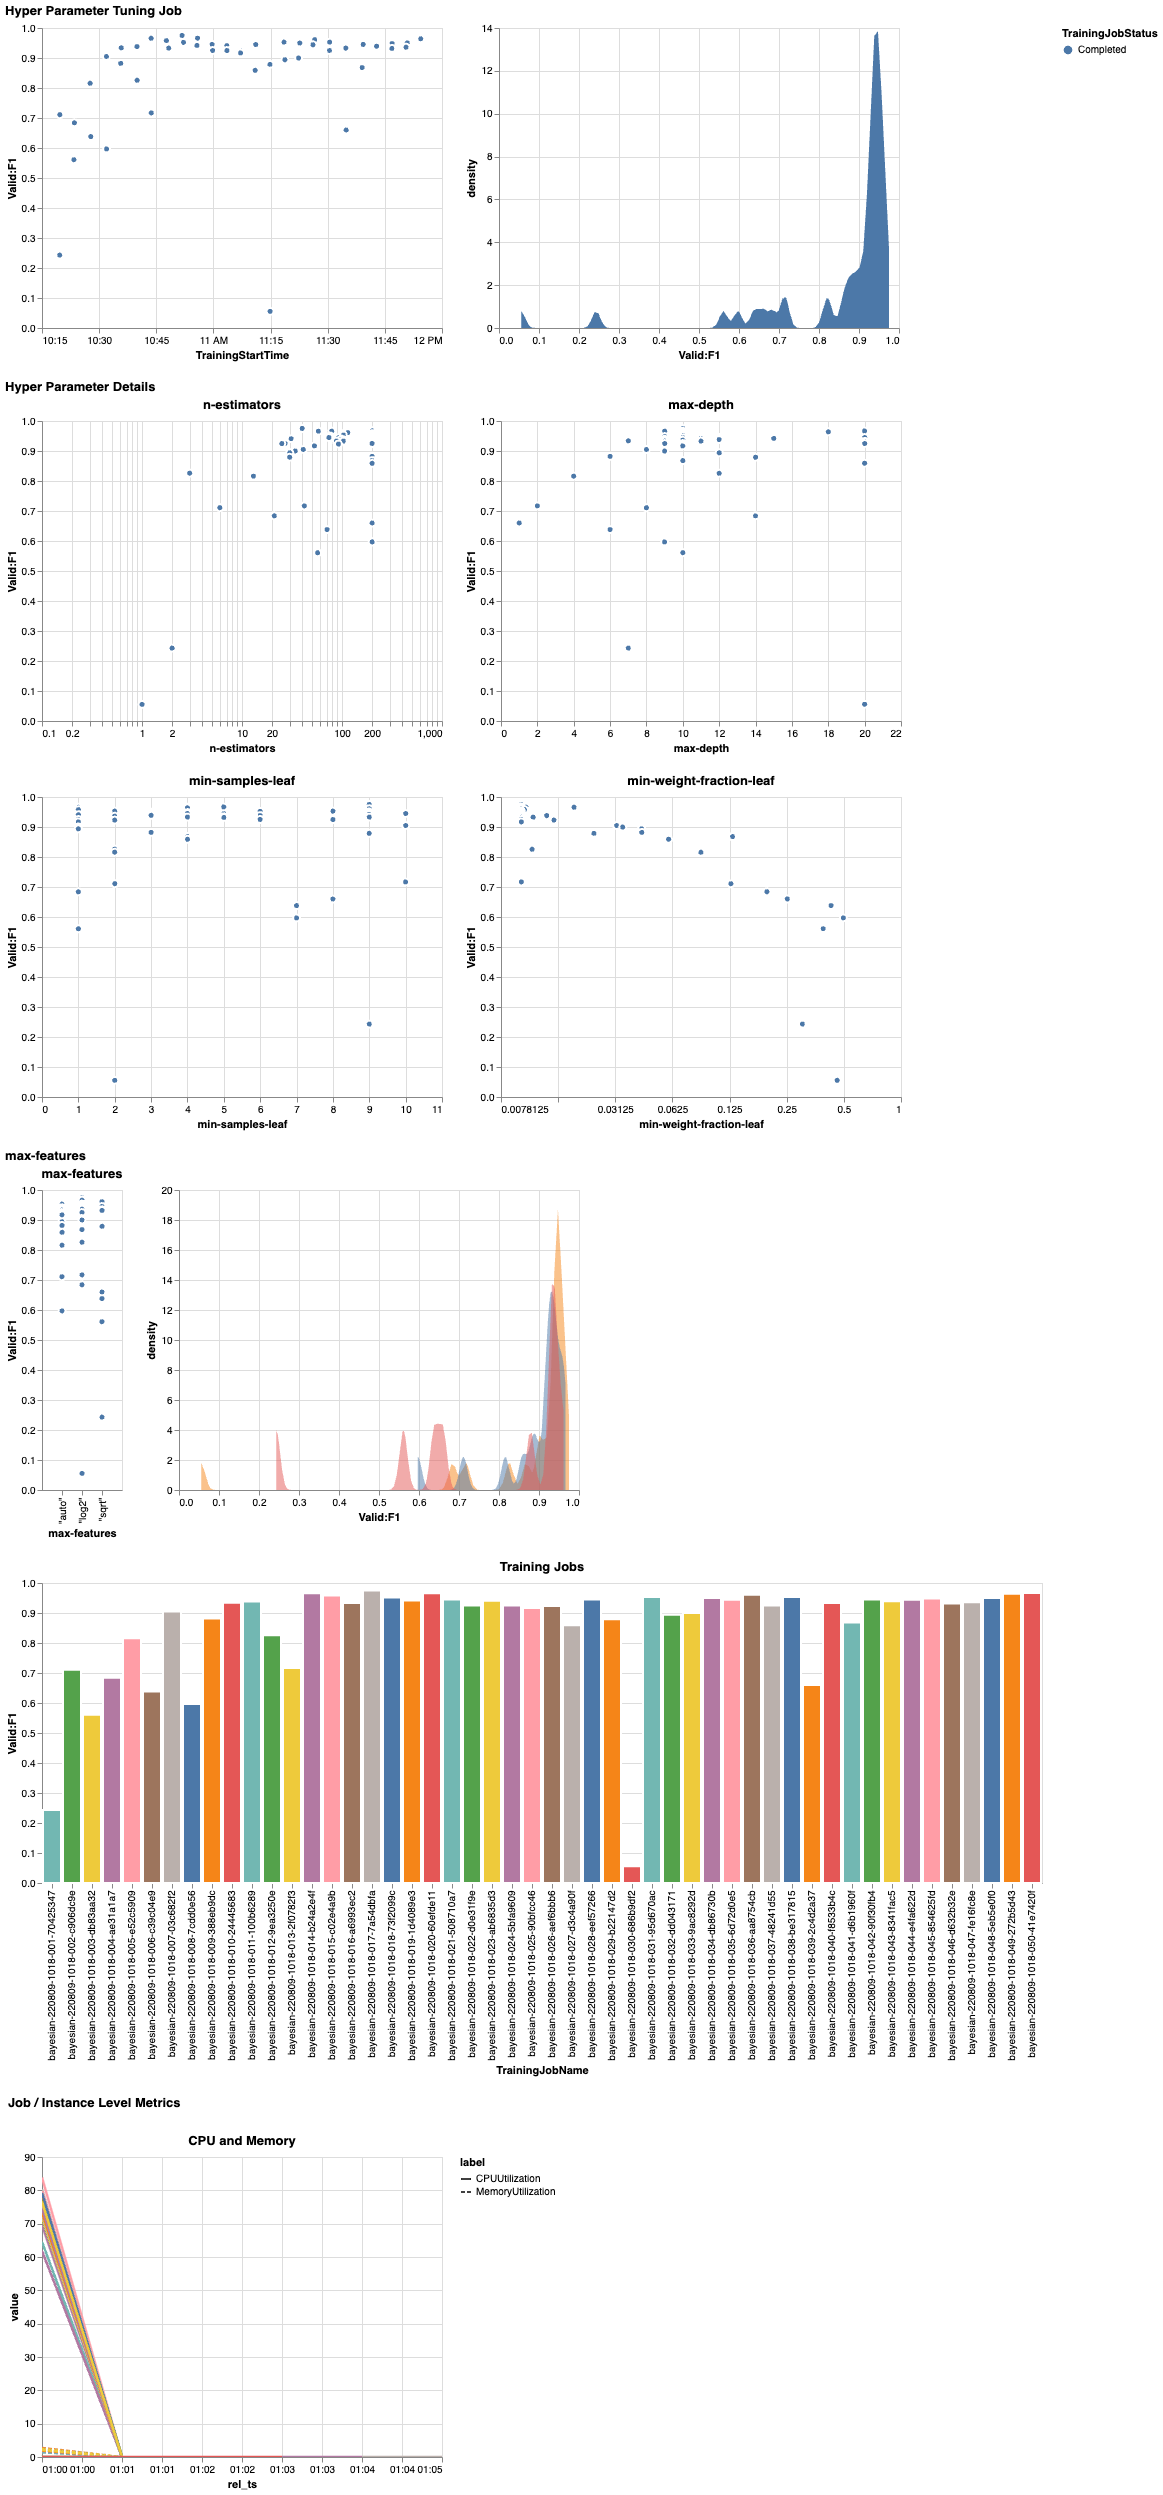

In [23]:
analyze_hpo_job(bayesian_tuner)

### Both

Tuning job bayesian-220809-1018      status: Completed
Tuning job random-220809-1018        status: Completed

Number of training jobs with valid objective: 100
Lowest: 0.05550000071525574 Highest 0.9750000238418579


max-depth max-features  min-samples-leaf  min-weight-fraction-leaf  n-estimators                    TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds         TuningJobName  Valid:F1
33       10.0       "log2"               9.0                  0.010000          40.0  bayesian-220809-1018-017-7a54dbfa         Completed 2022-08-09 10:51:46+02:00 2022-08-09 10:53:43+02:00                       117.0  bayesian-220809-1018     0.975
0        20.0       "log2"               5.0                  0.010000         200.0  bayesian-220809-1018-050-41e7420f         Completed 2022-08-09 11:54:46+02:00 2022-08-09 11:56:38+02:00                       112.0  bayesian-220809-1018     0.967
36        9.0       "log2"               4.0                  0.010578          79.0  bayesian-220809-1018-014-b24a2e4f         Completed 2022-08-09 10:43:39+02:00 2022-08-09 10:46:20+02:00                       161.0  bayesian-220809-1018     0.966
30       10.0       "auto"               1.0                  0.018942          58.0  bayesian-220809-1018-020-60efde11         Completed 2022-08-09 10:55:49+02:00 2022-08-09 10:57:55+02:00                       126.0  bayesian-220809-1018     0.966
1        18.0       "auto"               4.0                  0.010000         110.0  bayesian-220809-1018-049-272b5d43         Completed 2022-08-09 11:54:25+02:00 2022-08-09 11:56:25+02:00                       120.0  bayesian-220809-1018     0.964
14       10.0       "sqrt"               9.0                  0.010000         114.0  bayesian-220809-1018-036-aa8754cb         Completed 2022-08-09 11:26:34+02:00 2022-08-09 11:28:36+02:00                       122.0  bayesian-220809-1018     0.961
35       10.0       "auto"               1.0                  0.010376         200.0  bayesian-220809-1018-015-c02e4a9b         Completed 2022-08-09 10:47:39+02:00 2022-08-09 10:49:36+02:00                       117.0  bayesian-220809-1018     0.958
19       10.0       "auto"               8.0                  0.010000         200.0  bayesian-220809-1018-031-95d670ac         Completed 2022-08-09 11:18:31+02:00 2022-08-09 11:20:33+02:00                       122.0  bayesian-220809-1018     0.953
12       10.0       "log2"               2.0                  0.010000         103.0  bayesian-220809-1018-038-be317815         Completed 2022-08-09 11:30:30+02:00 2022-08-09 11:32:32+02:00                       122.0  bayesian-220809-1018     0.953
32       10.0       "log2"               6.0                  0.010000         200.0  bayesian-220809-1018-018-73f2099c         Completed 2022-08-09 10:52:09+02:00 2022-08-09 10:54:11+02:00                       122.0  bayesian-220809-1018     0.952

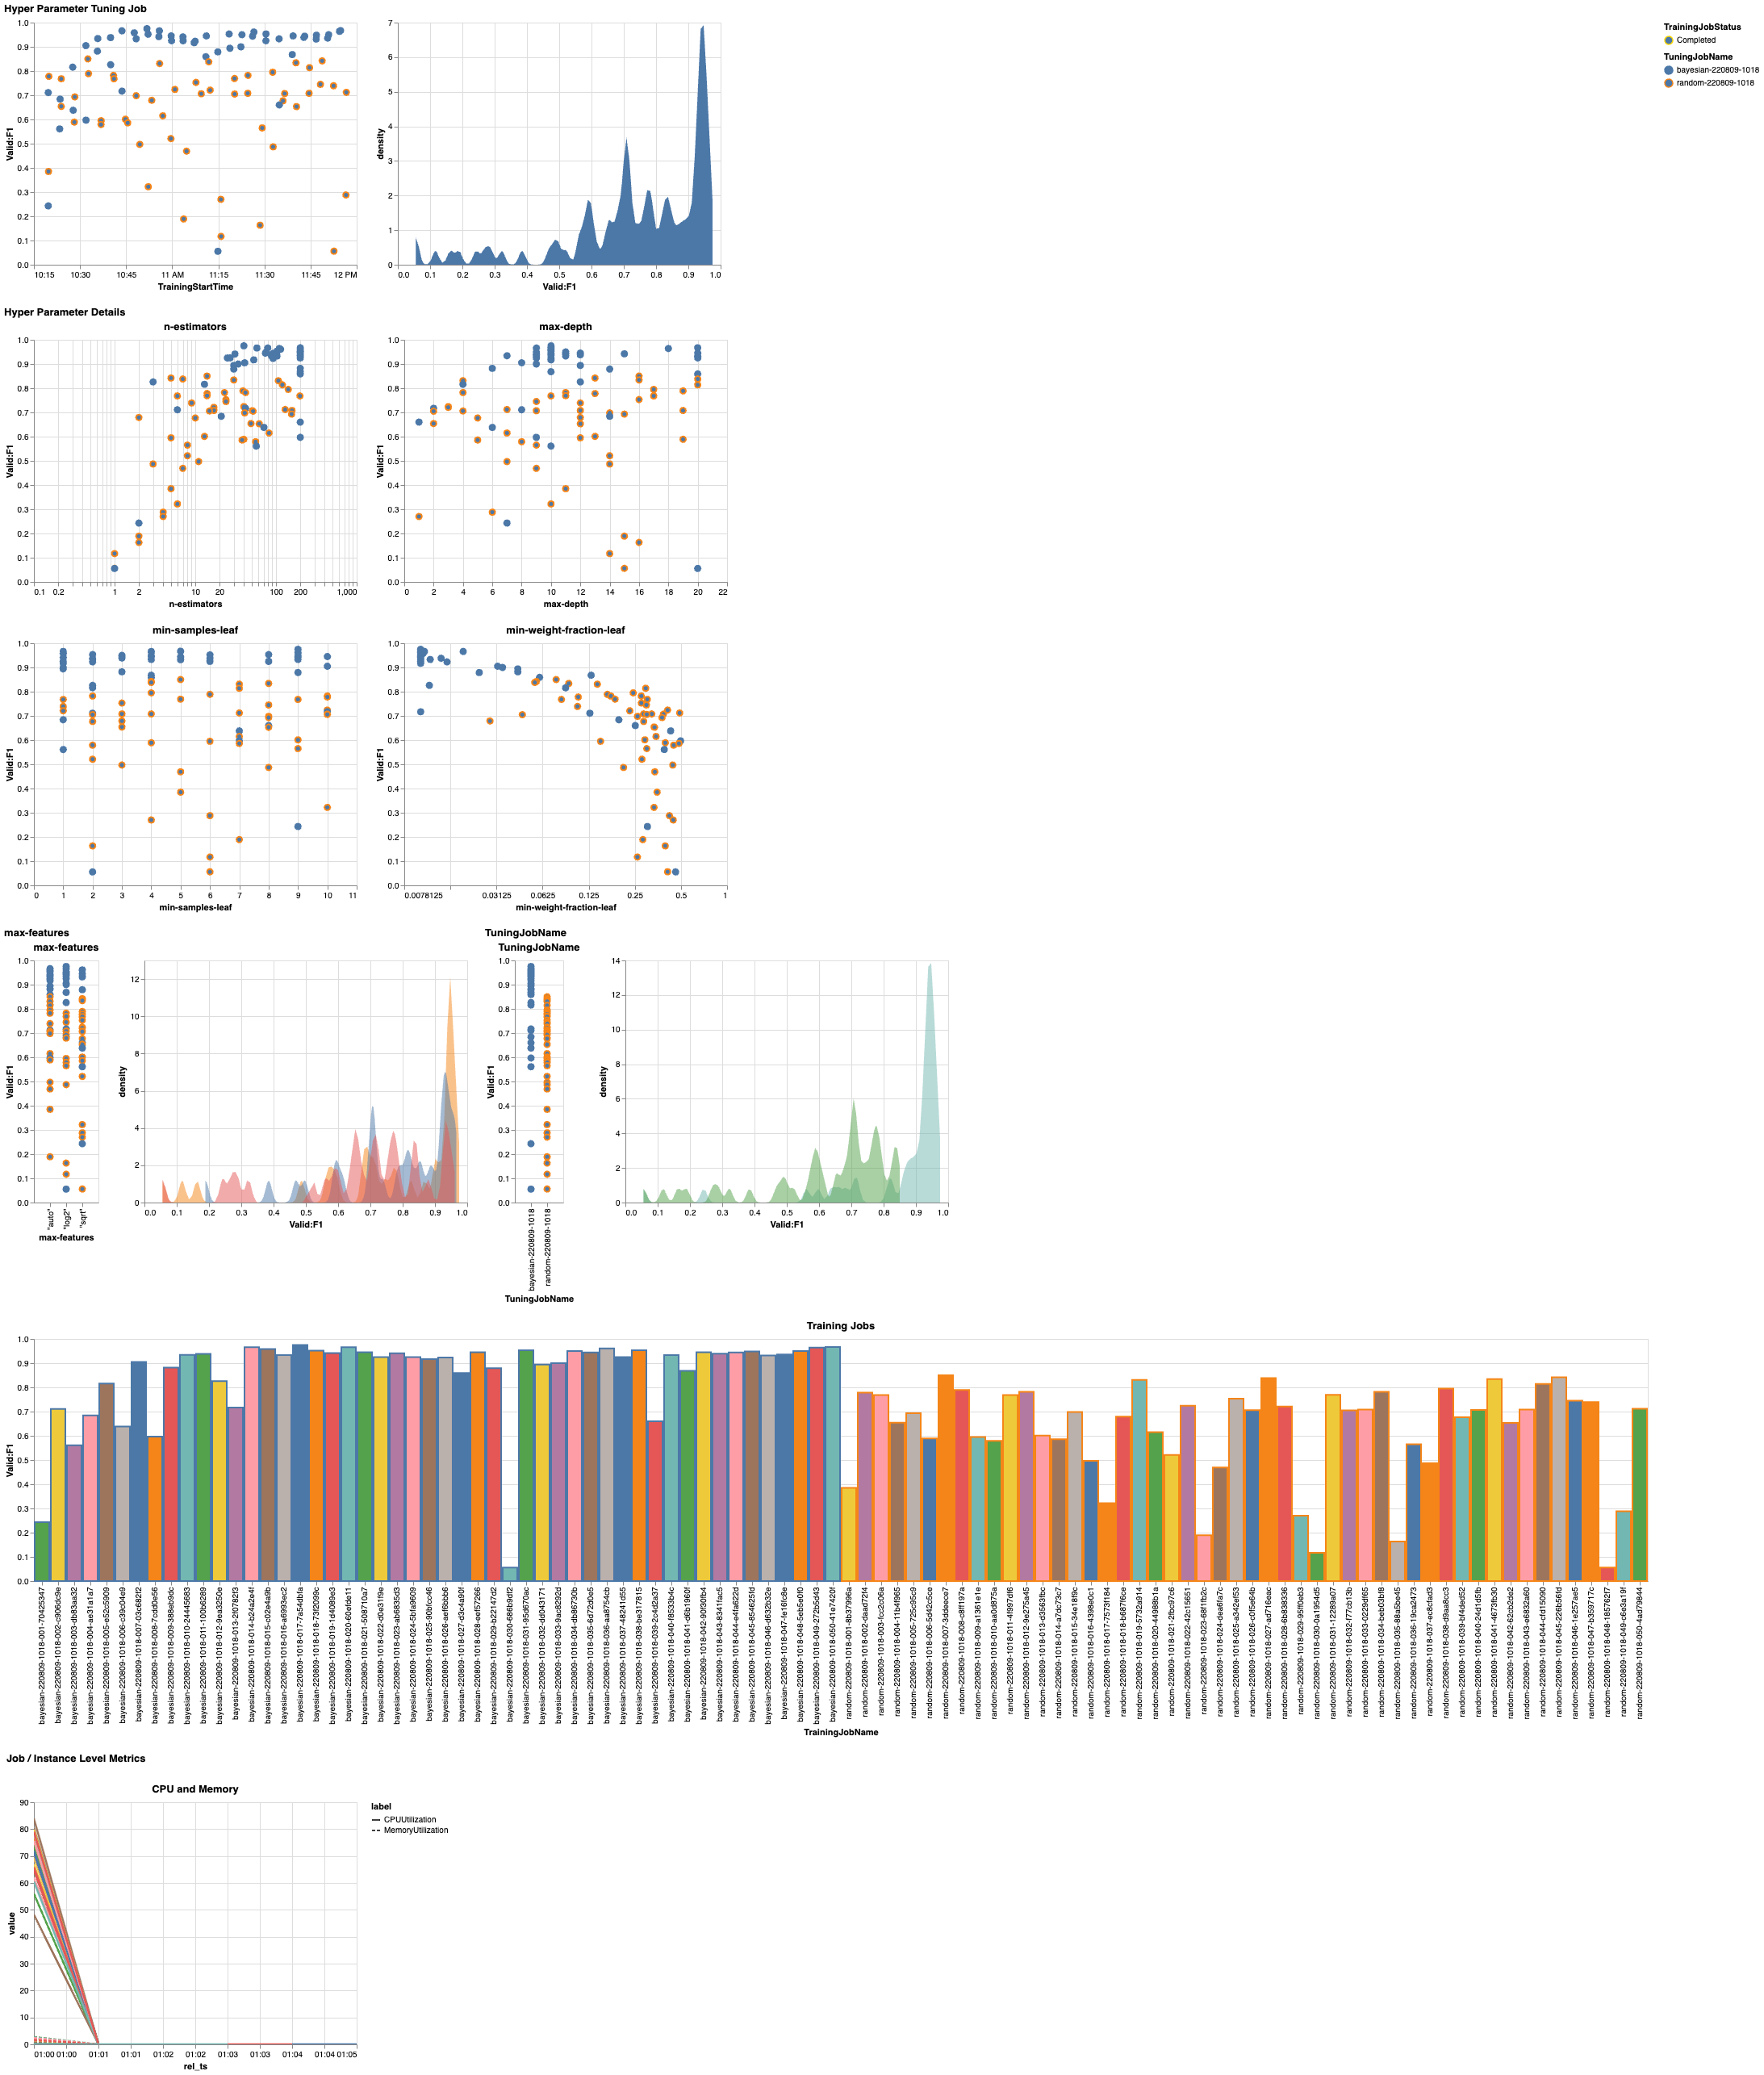

In [24]:
analyze_hpo_job(tuning_jobs)

### Bayesian, warmstart

Let's now use our better understanding of good hyper parameter value ranges to do more searching. But we do not start from scratch, but warmstart a new HPO Job, that incorporates what was learned during the previous HPO run.

In [25]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

warm_start_config = WarmStartConfig(warm_start_type=WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, 
                                    parents=[bayesian_tuner_name, random_tuner_name]) # Recognize how we point to the previous tuning jobs (both Bayesian and Random)
tuner_parameters['warm_start_config'] =  warm_start_config

# repeated from above, then adjusted based on the runs from above. This is just an illustration, YMMV.
hpt_ranges = {'n-estimators': IntegerParameter(100, 300), # was (1,200). Many of the good values fell onto 200, maybe more is better?
              'max-depth': IntegerParameter(6, 24), # was (1, 20). Many of the good values fell on 20. Maybe more is better?
              'min-samples-leaf': IntegerParameter(1, 6), # was (1, 10) But there were not additional gains above 6.
              'min-weight-fraction-leaf': ContinuousParameter(0.001, 0.15), # was (0.01, 0.5)
              'max-features': CategoricalParameter(['auto', 'log2', 'sqrt'])} # unchanged. Inconclusive with the wide value ranges we searched. 
                                                                              # So let's try again with the narrower search from above.
tuner_parameters['hyperparameter_ranges'] = hpt_ranges
tuner_parameters['base_tuning_job_name'] = 'bayesian-warm'
tuner_parameters['max_jobs'] = n//2 # we can reduce the number of trials, as we already build on what we learned already
tuner_parameters['max_parallel_jobs'] = 1

warmstarted_tuner = HyperparameterTuner(**tuner_parameters)
warmstarted_tuner.fit({'train': s3_data_url}, wait=False)
warmstarted_tuner_name = warmstarted_tuner.describe()["HyperParameterTuningJobName"]
print(f'tuning job submitted: {warmstarted_tuner_name}.')

tuning job submitted: bayesian-warm-220809-1200.


In [26]:
warmstarted_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Tuning job bayesian-warm-220809-1200's parents: bayesian-220809-1018, random-220809-1018
Tuning job bayesian-220809-1018      status: Completed
Tuning job random-220809-1018        status: Completed
Tuning job bayesian-warm-220809-1200 status: Stopped

Number of training jobs with valid objective: 122
Lowest: 0.05550000071525574 Highest 0.9860000014305115


max-depth max-features  min-samples-leaf  min-weight-fraction-leaf  n-estimators                         TrainingJobName TrainingJobStatus         TrainingStartTime           TrainingEndTime  TrainingElapsedTimeSeconds              TuningJobName  Valid:F1
20       11.0       "auto"               6.0                  0.002094         176.0  bayesian-warm-220809-1200-003-5df824b4         Completed 2022-08-09 12:10:40+02:00 2022-08-09 12:12:42+02:00                       122.0  bayesian-warm-220809-1200     0.986
1        24.0       "log2"               3.0                  0.001007         112.0  bayesian-warm-220809-1200-022-578d8641         Completed 2022-08-09 13:30:44+02:00 2022-08-09 13:32:42+02:00                       118.0  bayesian-warm-220809-1200     0.983
11       18.0       "log2"               2.0                  0.001258         192.0  bayesian-warm-220809-1200-012-42626e80         Completed 2022-08-09 12:49:04+02:00 2022-08-09 12:51:07+02:00                       123.0  bayesian-warm-220809-1200     0.978
6        24.0       "log2"               3.0                  0.001651         157.0  bayesian-warm-220809-1200-017-74c30eed         Completed 2022-08-09 13:08:23+02:00 2022-08-09 13:10:20+02:00                       117.0  bayesian-warm-220809-1200     0.975
33       10.0       "log2"               9.0                  0.010000          40.0       bayesian-220809-1018-017-7a54dbfa         Completed 2022-08-09 10:51:46+02:00 2022-08-09 10:53:43+02:00                       117.0       bayesian-220809-1018     0.975
19       17.0       "auto"               5.0                  0.002344         136.0  bayesian-warm-220809-1200-004-cd357023         Completed 2022-08-09 12:14:52+02:00 2022-08-09 12:16:49+02:00                       117.0  bayesian-warm-220809-1200     0.969
0        20.0       "log2"               5.0                  0.010000         200.0       bayesian-220809-1018-050-41e7420f         Completed 2022-08-09 11:54:46+02:00 2022-08-09 11:56:38+02:00                       112.0       bayesian-220809-1018     0.967
18        9.0       "log2"               5.0                  0.001645         251.0  bayesian-warm-220809-1200-005-142614ab         Completed 2022-08-09 12:18:32+02:00 2022-08-09 12:20:30+02:00                       118.0  bayesian-warm-220809-1200     0.967
17       24.0       "log2"               6.0                  0.001654         232.0  bayesian-warm-220809-1200-006-daf5e376         Completed 2022-08-09 12:23:30+02:00 2022-08-09 12:25:32+02:00                       122.0  bayesian-warm-220809-1200     0.967
30       10.0       "auto"               1.0                  0.018942          58.0       bayesian-220809-1018-020-60efde11         Completed 2022-08-09 10:55:49+02:00 2022-08-09 10:57:55+02:00                       126.0       bayesian-220809-1018     0.966

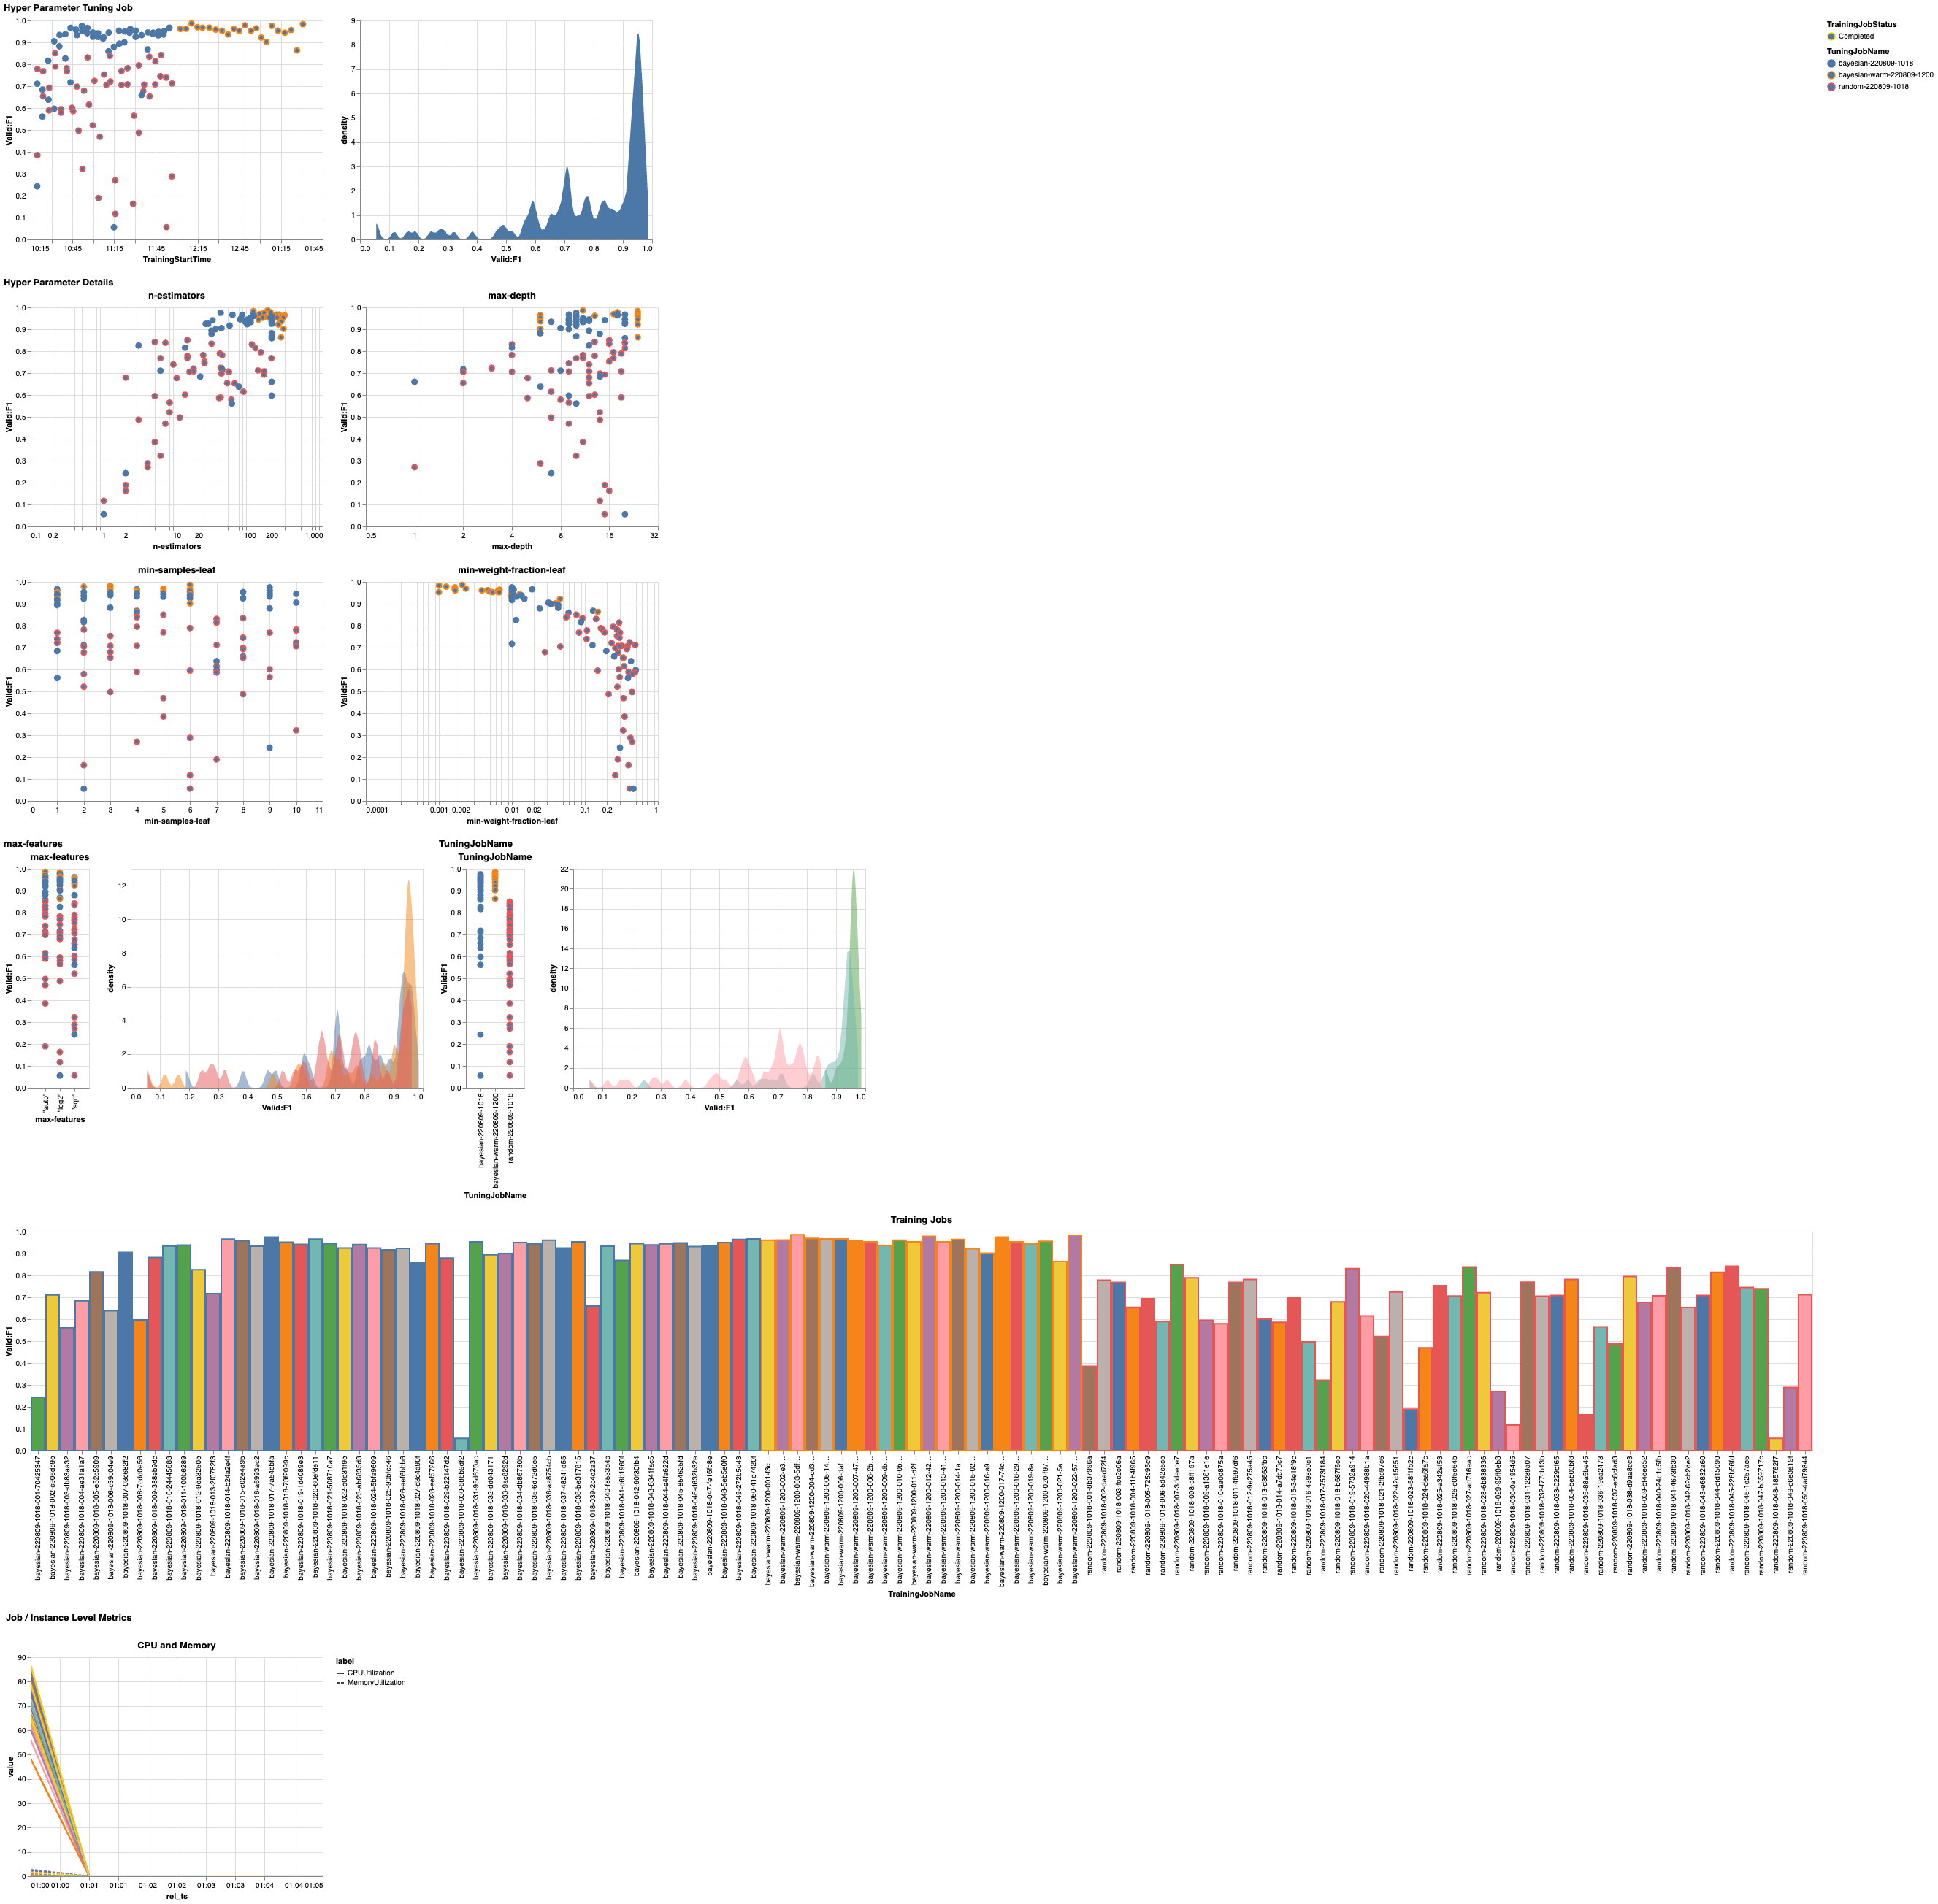

In [27]:
analyze_hpo_job(warmstarted_tuner)

## Please Note

As it turns out to use the existing knowledge in our heads (the understanding of hyper parameter value ranges) together with the captured knowledge in SageMaker Automatic Model Tuning (the previous trials that we now use using warmstart), we were able to continue to improve on the objective. And the overall result was much better. 

Also, recognize above how SageMaker HPO pre-dominantly probed the areas that were previously unexplored. The data points with the orange outline belong to the second optimization run.

### Open:
    
- How about using an example that show progress over epochs?
- Filtering of results by objective?
- Early Stopping?